## Description
In the follwoing notebook, the csv data file for KfZ-Zulassung and Hagel data for each canton are 
combined to create visualizations about locations with higher risk for the insurance

* [Necessary Python libraries](#python_libraries)

* [Reading interim data](#reading_data)

* [Data Visualization for KfZ Data](#data_visualization)


In [1]:
import os
from pathlib import Path
#import xarray as xr
import pandas as pd
import numpy as np
import copy

In [2]:
# Files are saved in the "processed" folder 
processed_data_path = Path("./data/processed")

kfz_data = pd.read_csv(processed_data_path/'interim_kfz_data.csv', sep=";")
hail_data = pd.read_csv(processed_data_path/'haildata_per_month_canton.csv', sep=",")

In [3]:
# Selecting certain columns
columns_to_select = ['year', 'canton', 'haildays_per_point']

# Deep copy of selected columns
hail_data_copy = copy.deepcopy(hail_data[columns_to_select])

#changing names of columns so that we have similar names between hail and kfz data
# Rename columns using a dictionary
new_column_names = {
    'year': 'Jahr',
    'canton': 'Kanton',
    'haildays_per_point': 'number of hail days'
}

hail_data_copy = hail_data_copy.rename(columns=new_column_names)


In [4]:
hail_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Jahr                 541 non-null    int64  
 1   Kanton               541 non-null    object 
 2   number of hail days  541 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 12.8+ KB


In [5]:
kfz_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Kanton     468 non-null    object
 1   Jahr       468 non-null    int64 
 2   Total_KFZ  468 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 11.1+ KB


In [7]:
#kfz_data['Jahr'] = pd.to_datetime(kfz_data['Jahr'], format='%Y').dt.strftime('%Y')

### Merge haildays and kfz dataframes by multiindex

In [6]:
#Because the KfZ data is available only after 2005, the data from hail dataframe is filtered first

# Filter the data in the first dataframe based on Jahr >= 2005
hail_data_filtered = hail_data_copy[hail_data_copy['Jahr'] >= 2005]

# Perform the inner join on Kanton and Jahr columns
kfz_hail_df = pd.merge(hail_data_filtered, kfz_data, on=['Kanton', 'Jahr'], how='inner')

# Print the merged dataframe header
kfz_hail_df.head()


,Jahr,Kanton,number of hail days,Total_KFZ
0,2005,AG,0.669080,311370
1,2006,AG,1.283128,316298
2,2007,AG,0.573497,321731
3,2008,AG,0.632875,327074
4,2009,AG,1.837075,329151


In [7]:
# A new column is created by multiply elements of column "number of hail days" and "Total-KFZ" 
# The Unite of the new column is "day-car". Idea here is that risk is proportional to number of haildays and number of cars
# as an example, if there were 100 cars in a specific canton and 10 days of hail, the risk is assumed to be equal 
# to the case where we had 1000 cars and 1 day with hail.

kfz_hail_df["hailday_kfz"] =kfz_hail_df.apply(lambda row: row['number of hail days'] * row['Total_KFZ'], axis=1)


In [16]:
# Column Jahr is in int64 format so we covert that column 
kfz_hail_df['Jahr'] = pd.to_datetime(kfz_hail_df['Jahr'], format='%Y').dt.strftime('%Y')

kfz_hail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463 entries, 0 to 462
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Jahr                    463 non-null    object 
 1   Kanton                  463 non-null    object 
 2   number of hail days     463 non-null    float64
 3   Total_KFZ               463 non-null    int64  
 4   hailday_kfz             463 non-null    float64
 5   hailday_kfz_normalized  463 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 25.3+ KB


In [18]:
# To make more sense of the data, the *hailday_kfz* is normalized per 100k autos.

kfz_hail_df['hailday_kfz_normalized'] = kfz_hail_df['hailday_kfz'] / 100000

In [19]:
kfz_hail_df.head()

,Jahr,Kanton,number of hail days,Total_KFZ,hailday_kfz,hailday_kfz_normalized
0,2005,AG,0.669080,311370,208331.556843,2.083316
1,2006,AG,1.283128,316298,405850.873280,4.058509
2,2007,AG,0.573497,321731,184511.913106,1.845119
3,2008,AG,0.632875,327074,206996.868936,2.069969
4,2009,AG,1.837075,329151,604674.936278,6.046749


## Visualization of combined results

### Bar running chart

In [11]:
!pip install bar_chart_race

Defaulting to user installation because normal site-packages is not writeable


In [12]:
import bar_chart_race as bcr

In [20]:
# Convert to wide format
kfz_hail_wide = kfz_hail_df.pivot(index='Jahr', columns='Kanton', values='hailday_kfz_normalized')

In [14]:
kfz_hail_wide.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 2005 to 2022
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AG      18 non-null     float64
 1   AI      18 non-null     float64
 2   AR      18 non-null     float64
 3   BE      18 non-null     float64
 4   BL      18 non-null     float64
 5   BS      15 non-null     float64
 6   FR      18 non-null     float64
 7   GE      16 non-null     float64
 8   GL      18 non-null     float64
 9   GR      18 non-null     float64
 10  JU      18 non-null     float64
 11  LU      18 non-null     float64
 12  NE      18 non-null     float64
 13  NW      18 non-null     float64
 14  OW      18 non-null     float64
 15  SG      18 non-null     float64
 16  SH      18 non-null     float64
 17  SO      18 non-null     float64
 18  SZ      18 non-null     float64
 19  TG      18 non-null     float64
 20  TI      18 non-null     float64
 21  UR      18 non-null     float64
 22 

Important note: **ffmpeg** should be installed on the computer to run the following race bar chart.

For Windows:

1. Visit the official ffmpeg website: https://www.ffmpeg.org/download.html.
2. Scroll down to the "Windows Builds" section and click on the link corresponding to "Download FFmpeg".
3. Choose the appropriate version based on your system architecture (32-bit or 64-bit).
4. Extract the downloaded zip file to a directory of your choice.
5. Add the path to the ffmpeg executable (e.g., ffmpeg/bin) to your system's PATH environment variable.

For macOS:

1. Open a terminal.
2. Install Homebrew if you haven't already. Visit the Homebrew website (https://brew.sh/) and follow the installation instructions.
3. Once Homebrew is installed, run the following command in the terminal:

- *brew install ffmpeg*

For Linux (Ubuntu):

1. Open a terminal.
2. Run the following command to install ffmpeg:
    
- *sudo apt-get update*
- *sudo apt-get install ffmpeg*


In [51]:
import warnings
warnings.filterwarnings('ignore')

# for settings, see here: https://www.dexplo.org/bar_chart_race/api/

bcr.bar_chart_race(
    df = kfz_hail_wide, 
    title = "Hageltagen x Anzahl Autos per Kanton (x100k)", 
    n_bars=10, 
    orientation='h', 
    fixed_order= False,
    fixed_max = True,
    cmap = 'prism',
    steps_per_period=10, 
    period_length=1000, 
    label_bars = False)
     

In [ ]:
# create a grid of subplots for each year
# Set the range for the choropleth
title = 'Hageltagen x Anzahl Autos per Kanton (x100k)'
col = 'Total_KFZ'
#source = 'Source: ...'
vmin = canton_data[col].min()
vmax = canton_data[col].max()
cmap = 'YlOrRd'

fig = plt.figure(figsize=(18, 18))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 3), axes_pad=0.1)


# loop over each year and create a heatmap on the corresponding subplot
years = df['Jahr'].unique()
for i, year in enumerate(years):
    year_data = canton_data[canton_data['Jahr']==year]
    ax = grid[i]
    ax.axis('off')
    ax.set_title(str(year))
    year_data.plot(column=col, cmap=cmap, linewidth=1, ax=ax)
    
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
# Empty array for the data range
sm._A = []
# Add the colorbar to the figure
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)

fig.suptitle(title, fontsize=18)

plt.show()







In [42]:
s= kfz_hail_wide.iloc[0]

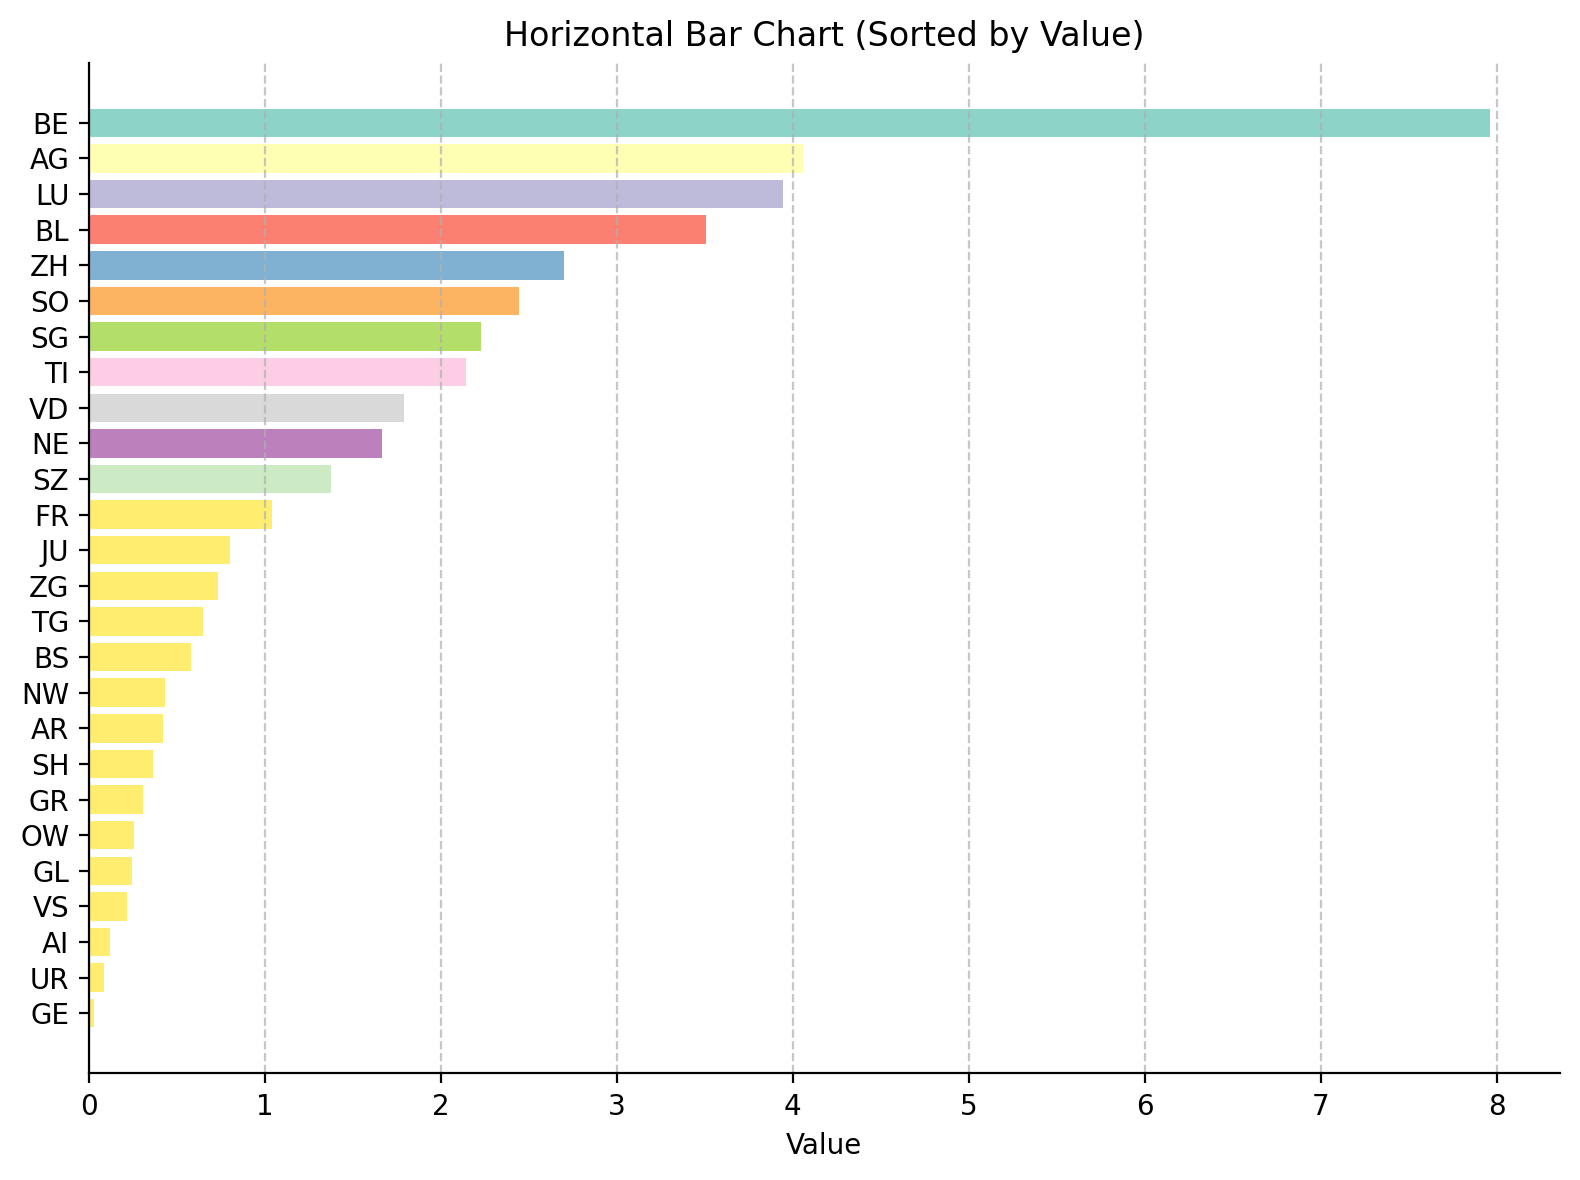

In [40]:
import matplotlib.pyplot as plt

# Sort the data in descending order
sorted_data = s.sort_values(ascending=False)

# Increase the figure size and DPI for better resolution
fig, ax = plt.subplots(figsize=(8, 6), dpi=200)

# Choose a different color palette for better distinction between bars
colors = plt.cm.Set3(range(len(sorted_data)))

# Invert the y-axis to have higher values at the top
ax.invert_yaxis()

# Add a grid for better readability
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Remove the right and top spines for cleaner appearance
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add labels to the x-axis
ax.set_xlabel('Value')

# Add a title to the chart
ax.set_title('Horizontal Bar Chart (Sorted by Value)')

# Plot the sorted horizontal bar chart
ax.barh(y=sorted_data.index, width=sorted_data.values, color=colors)

# Adjust the spacing between ticks on the y-axis
ax.set_yticks(range(len(sorted_data)))
ax.set_yticklabels(sorted_data.index)

# Automatically adjust the layout to prevent labels from being cut off
plt.tight_layout()

# Show the chart
plt.show()
